#### CESM-HR SST (DJF) trends for the periods 1965–2005 and 2060–2100"
- Read HIST
- Read RCP85
- Seasonal average
- Calculate trend
- Plotting
 
Ming Ge April 2025

In [2]:
import glob
import os
from pathlib import Path
import numpy as np
import xarray as xr
import uxarray as ux 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker, cm
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings 

import geoviews as gv
# geoviews.feature is a convenient wrapper around Cartopy's built-in 
# geographical features, like coastlines, borders, rivers, and land/ocean.
import geoviews.feature as gf
# opts is a method from HoloViews (which GeoViews is built on) 
# used to customize plot appearance — 
# like colorbars, axes, titles, line widths, etc.
from geoviews import opts
import holoviews as hv
# Tell HoloViews (and hvplot) to use the Matplotlib backend for rendering plots
hv.extension("matplotlib")
warnings.filterwarnings("ignore")
import helping_cesm 
from helping_cesm import plot_ux, plot_ux_list


#### Read HIST DJF

In [6]:
%%time
dir_o  = '/glade/campaign/mmm/c3we/mingge/CESM-HR/'
flnm_o = dir_o + 'TsTrend_DJF_1965-2005.nc'

n_mem = 10

year_s = 1965
year_e = 2005
n_year = year_e - year_s + 1

# Monthly Dec SST timed as 01-01
# Dec. Jan Feb
selected_months = [1, 2, 3]  
n_mon = len(selected_months)
start_date = str(year_s) + '-01-01'
end_date   = str(year_e) + '-03-01'

dir_hr = '/glade/campaign/collections/rda/data/d651007/'

name_0 = 'b.e13.BHISTC5.ne120_t12.cesm-ihesp-'
name_1 = '-1920-2005.'

period_1d = ['196001-196912', '197001-197912', '198001-198912', '199001-199912', '200001-200512']
n_period = len(period_1d)

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    is_first = True
    for nm in range(n_mem):
        if nm == 0:
            member_name = name_0 + 'sehires38-1850-2005.001'
        elif nm==1 or nm==2:
            member_name = name_0 + 'hires1.0.30' + name_1 + str(nm+1).zfill(3)
        elif nm==3 or nm==4:
            member_name = name_0 + 'hires1.0.44' + name_1 + str(nm+1).zfill(3)
        elif nm==5:
            member_name = name_0 + 'hires1.0.45' + name_1 + str(nm+1).zfill(3)
        else:
            member_name = name_0 + 'hires1.0.46' + name_1 + str(nm+1).zfill(3)

        dir_0 = dir_hr + member_name + '/atm/proc/tseries/month_1/'
        nmon_s = 0
        for nn in range(n_period):
            
            flnm = dir_0 + member_name + \
                '.cam.h0.TS.'+ period_1d[nn] + '.nc'
            
            with xr.open_dataset(flnm) as ds:
                #print(flnm)
                # select data corresponding to selected_months
                ts = ds.TS.sel(time=ds.time.dt.month.isin(selected_months)) \
                            .sel(time=slice(None, end_date))\
                            .sel(time=slice(start_date, None))
                nmon_e = nmon_s + ts.shape[0]
                 
                if is_first == True:
                    n_col = ts.shape[1]
                    data_3d = np.zeros((n_mem, n_year*n_mon, n_col))
                    is_first = False
                
                #print(nmon_s,' - ', nmon_e, ts.shape)
                data_3d[nm, nmon_s:nmon_e] = ts
                nmon_s=nmon_e        

/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_1965-2005.nc exist
CPU times: user 215 μs, sys: 0 ns, total: 215 μs
Wall time: 218 μs


#### Seasonal average

In [7]:
if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    # 3 months average
    # ts_3d = np.zeros((n_mem, n_year*n_mon, n_col))
    ts_3d = np.zeros((n_mem, n_year, n_col))
    nn = 0
    n_s = 0
    for ny in range(n_year):        
        n_e = n_s + 3
        ts_3d[:,ny] = np.mean(data_3d[:,n_s:n_e], axis=1) 
        nn =+ 1
        n_s = n_e

/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_1965-2005.nc exist


#### Calculate trend and save it as a dataset

In [8]:
%%time
if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    # Fill value -99
    trend_2d = np.zeros((n_mem, n_col)) - 99
    # Time vector for regression
    tt = np.arange(n_year)

    # Loop over mem, lat-lon grid and fit a linear trend
    for nm in range(n_mem):
        print(nm)
        for ii in range(n_col):
            yy = ts_3d[nm, :, ii]
            # Fit line: degree=1 returns [slope, intercept]
            slope, intercept = np.polyfit(tt, yy, 1)
            trend_2d[nm, ii] = slope  # Save the trend (slope)

    # Create the DataArray
    trend_da = xr.DataArray(
        trend_2d,
        dims=['member', 'ncol'],
        name='ts_trend'
    )

    # Combine into a Dataset
    ds = xr.Dataset({
        "ts_trend": trend_da,
        "lat": ds.lat,
        "lon": ds.lon
    })

    ds.to_netcdf(flnm_o)

/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_1965-2005.nc exist
CPU times: user 172 μs, sys: 0 ns, total: 172 μs
Wall time: 175 μs


#### Read CESM HR RCP85 (2006-2100) simulations.

In [9]:
%%time
dir_hr = '/glade/campaign/collections/rda/data/d651009/'
flnm_o = dir_o + 'TsTrend_DJF_2060-2100.nc'
name_0 = 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-'
name_1 = '-2006-2100.'

period_1d = ['205601-206512', '206601-207512','207601-208512','208601-209512', '209601-210012']
n_period = len(period_1d)

year_s = 2060
year_e = 2100
n_year = year_e - year_s + 1

# Monthly Dec SST timed as 01-01
# Dec. Jan Feb
selected_months = [1, 2, 3]  
n_mon = len(selected_months)
start_date = str(year_s) + '-01-01'
end_date   = str(year_e) + '-03-01'


if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    is_first = True
    for nm in range(n_mem):
        if nm == 0:
            member_name = name_0 + 'sehires38' + name_1 + str(nm+1).zfill(3)
        elif nm==1:
            member_name = name_0 + 'hires1.0.30' + name_1 + str(nm+1).zfill(3)
        elif nm==2:
            member_name = name_0 + 'hires1.0.31' + name_1 + str(nm+1).zfill(3)
        elif nm==4 or nm==3:
            member_name = name_0 + 'hires1.0.44' + name_1 + str(nm+1).zfill(3)
        else:
            member_name = name_0 + 'hires1.0.46' + name_1 + str(nm+1).zfill(3)

        dir_0 = dir_hr + member_name + '/atm/proc/tseries/month_1/'
        nmon_s = 0
        for nn in range(n_period):
            flnm = dir_0 + member_name + \
                '.cam.h0.TS.'+ period_1d[nn] + '.nc'
            
            with xr.open_dataset(flnm) as ds:
                #print(flnm)
                # select data corresponding to selected_months
                ts = ds.TS.sel(time=ds.time.dt.month.isin(selected_months)) \
                            .sel(time=slice(None, end_date))\
                            .sel(time=slice(start_date, None))
                             
                nmon_e = nmon_s + ts.shape[0]
                if is_first == True:
                    n_col = ts.shape[1]
                    data_3d = np.zeros((n_mem, n_year*n_mon, n_col))
                    is_first = False

                #print(nmon_s,nmon_e)
                data_3d[nm, nmon_s:nmon_e] = ts
                nmon_s=nmon_e


/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_2060-2100.nc exist
CPU times: user 1.23 ms, sys: 0 ns, total: 1.23 ms
Wall time: 2.82 ms


#### seasonal average

In [10]:
if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    # 3 months average
    # ts_3d = np.zeros((n_mem, n_year*n_mon, n_col))
    ts_3d = np.zeros((n_mem, n_year, n_col))
    nn = 0
    n_s = 0
    for ny in range(n_year):        
        n_e = n_s + 3
        ts_3d[:,ny] = np.mean(data_3d[:,n_s:n_e], axis=1) 
        nn =+ 1
        n_s = n_e

/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_2060-2100.nc exist


#### Calculate trend

In [11]:
%%time
if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    # Fill value -99
    trend_2d = np.zeros((n_mem, n_col)) - 99
    # Time vector for regression
    tt = np.arange(n_year)

    # Loop over mem, lat-lon grid and fit a linear trend
    for nm in range(n_mem):
        print(nm)
        for ii in range(n_col):
            yy = ts_3d[nm, :, ii]
            # Fit line: degree=1 returns [slope, intercept]
            slope, intercept = np.polyfit(tt, yy, 1)
            trend_2d[nm, ii] = slope  # Save the trend (slope)

    # Create the DataArray
    trend_da = xr.DataArray(
        trend_2d,
        dims=['member', 'ncol'],
        name='ts_trend'
    )

    # Combine into a Dataset
    ds = xr.Dataset({
        "ts_trend": trend_da,
        "lat": ds.lat,
        "lon": ds.lon
    })

    ds.to_netcdf(flnm_o)

/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_2060-2100.nc exist
CPU times: user 176 μs, sys: 0 ns, total: 176 μs
Wall time: 180 μs


#### Plotting

In [12]:
grid_base_path = "/glade/p/cesmdata/cseg/inputdata/share/meshes/"
grid_file_name = "ne120np4_ESMFmesh_cdf5_c20211018.nc"
grid_path = grid_base_path + grid_file_name

flnm_h = dir_o + 'TsTrend_DJF_1965-2005.nc'
flnm_f = dir_o + 'TsTrend_DJF_2060-2100.nc'

# Open a dataset (match the grid to the data)
uxds_h = ux.open_dataset(grid_path, flnm_h)
ts_trend_h = 10*uxds_h.ts_trend.mean(dim='member') 

# Open a dataset (match the grid to the data)
uxds_f = ux.open_dataset(grid_path, flnm_f)
ts_trend_f = 10*uxds_f.ts_trend.mean(dim='member') 


#### Ensemble mean DJF SST trend for 1965–2005

:Overlay
   .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
   .Land.I      :Feature   [Longitude,Latitude]
   .Lines.I     :Feature   [Longitude,Latitude]
   .Borders.I   :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
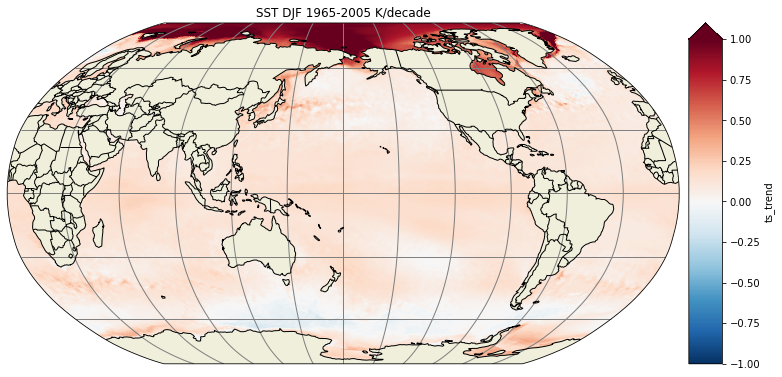

In [18]:
plot_ux(ts_trend_h, -1, 1, "RdBu_r", 'SST DJF 1965-2005 K/decade') 

#### Ensemble mean DJF SST trend for 2060-2100

:Overlay
   .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
   .Land.I      :Feature   [Longitude,Latitude]
   .Lines.I     :Feature   [Longitude,Latitude]
   .Borders.I   :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
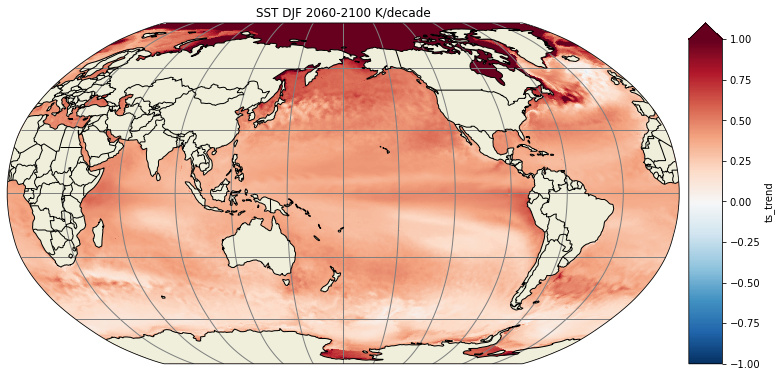

In [14]:
plot_ux(ts_trend_f, -1, 1, "RdBu_r", 'SST DJF 2060-2100 K/decade') 

#### DJF SST trend for each ensemble member from 1965 to 2005

:Layout
   .Overlay.I    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IV   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.V    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VI   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VII  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VIII :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IX   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.X    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
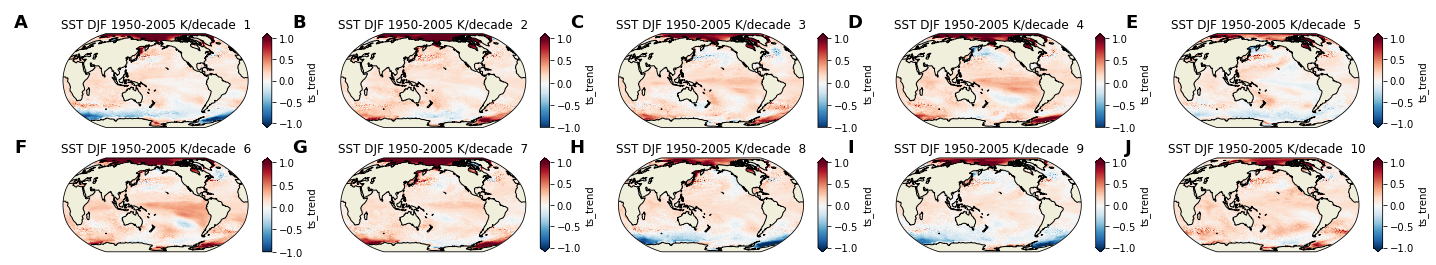

In [15]:
ts_1d = 10*uxds_h.ts_trend
plot_list = plot_ux_list(ts_1d, -1, 1, "RdBu_r", 'SST DJF 1950-2005 K/decade ')

layout = hv.Layout(plot_list).cols(5)
layout

#### DJF SST trend for each ensemble member from 2060-2100

:Layout
   .Overlay.I    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IV   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.V    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VI   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VII  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VIII :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IX   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.X    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude ts_trend)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
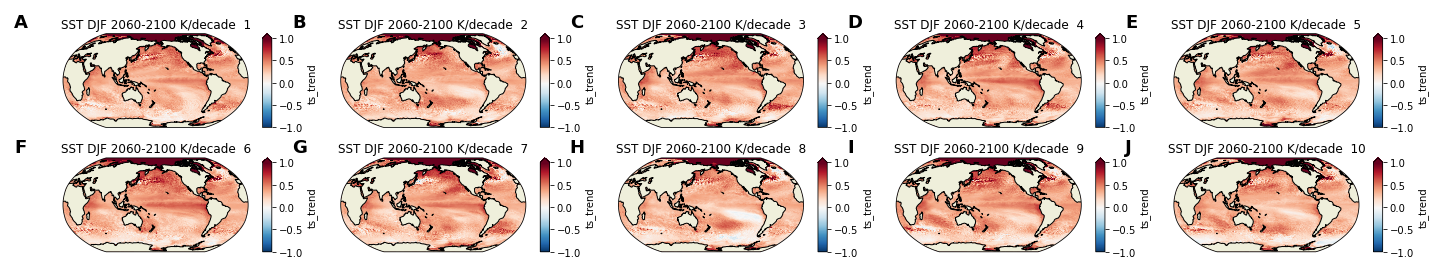

In [16]:
ts_f = 10*uxds_f.ts_trend
plot_list = plot_ux_list(ts_f, -1, 1, "RdBu_r", 'SST DJF 2060-2100 K/decade ')

layout = hv.Layout(plot_list).cols(5)
layout